# Permutation score analysis - Pancreas

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics
from velovi import VELOVI

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'permutation' / 'pancreas', exist_ok=True)

## Function definitions

In [5]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)

    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [6]:
def plot_phase_portrait(adata, gene, color, permuted=False, figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    df = pd.DataFrame(
        {
            'unspliced': adata[:, gene].layers['Mu'].squeeze().copy(),
            'spliced': adata[:, gene].layers['Ms'].squeeze().copy(),
            'color': color
        }
    )

    with mplscience.style_context():
        sns.scatterplot(data=df, x='spliced', y='unspliced', c=color, s=25, ax=ax);

        _, unspliced, spliced = compute_dynamics(adata, basis=gene, extrapolate=True, sort=True)
        df = pd.DataFrame(
            {
                'unspliced': unspliced.squeeze(),
                'spliced': spliced.squeeze(),
            }
        )

        ax.plot(spliced, unspliced, color="purple", linewidth=2)

        spliced_steady_state = np.linspace(np.min(spliced), np.max(spliced))
        unspliced_steady_state = adata.var.loc[gene, 'fit_gamma'] / adata.var.loc[gene, 'fit_beta'] * (spliced_steady_state - np.min(spliced_steady_state)) + np.min(unspliced)
        ax.plot(spliced_steady_state, unspliced_steady_state, color='purple', linestyle="--", linewidth=2);

    ax.axis('off')
    
    if SAVE_FIGURES:
        if permuted:
            fname = f'phase_portrait_{gene}_permuted'
        else:
            fname = f'phase_portrait_{gene}'
        fig.savefig(
            FIG_DIR / 'permutation' / 'pancreas' / f'{fname}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

In [7]:
def plot_perm_scores(adata, perm_scores, gene, color_label, figsize=(6, 4)):
    df = pd.DataFrame(perm_scores.loc[gene])
    df["Cell type"] = df.index
    order = adata.obs[color_label].cat.categories.tolist()
    
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(
            data=df,
            y=gene,
            x="Cell type",
            palette=adata.uns[f"{color_label}_colors"],
            order=order,
            ax=ax,
        )
        ax.set_ylim([-3.5, 15])
        ax.tick_params(axis='x', rotation=45)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'permutation' / 'pancreas' / f'permutation_score_{gene}.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )

## Data loading

In [8]:
adata = scv.datasets.pancreas(DATA_DIR / "pancreas" / "endocrinogenesis_day15.h5ad")
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

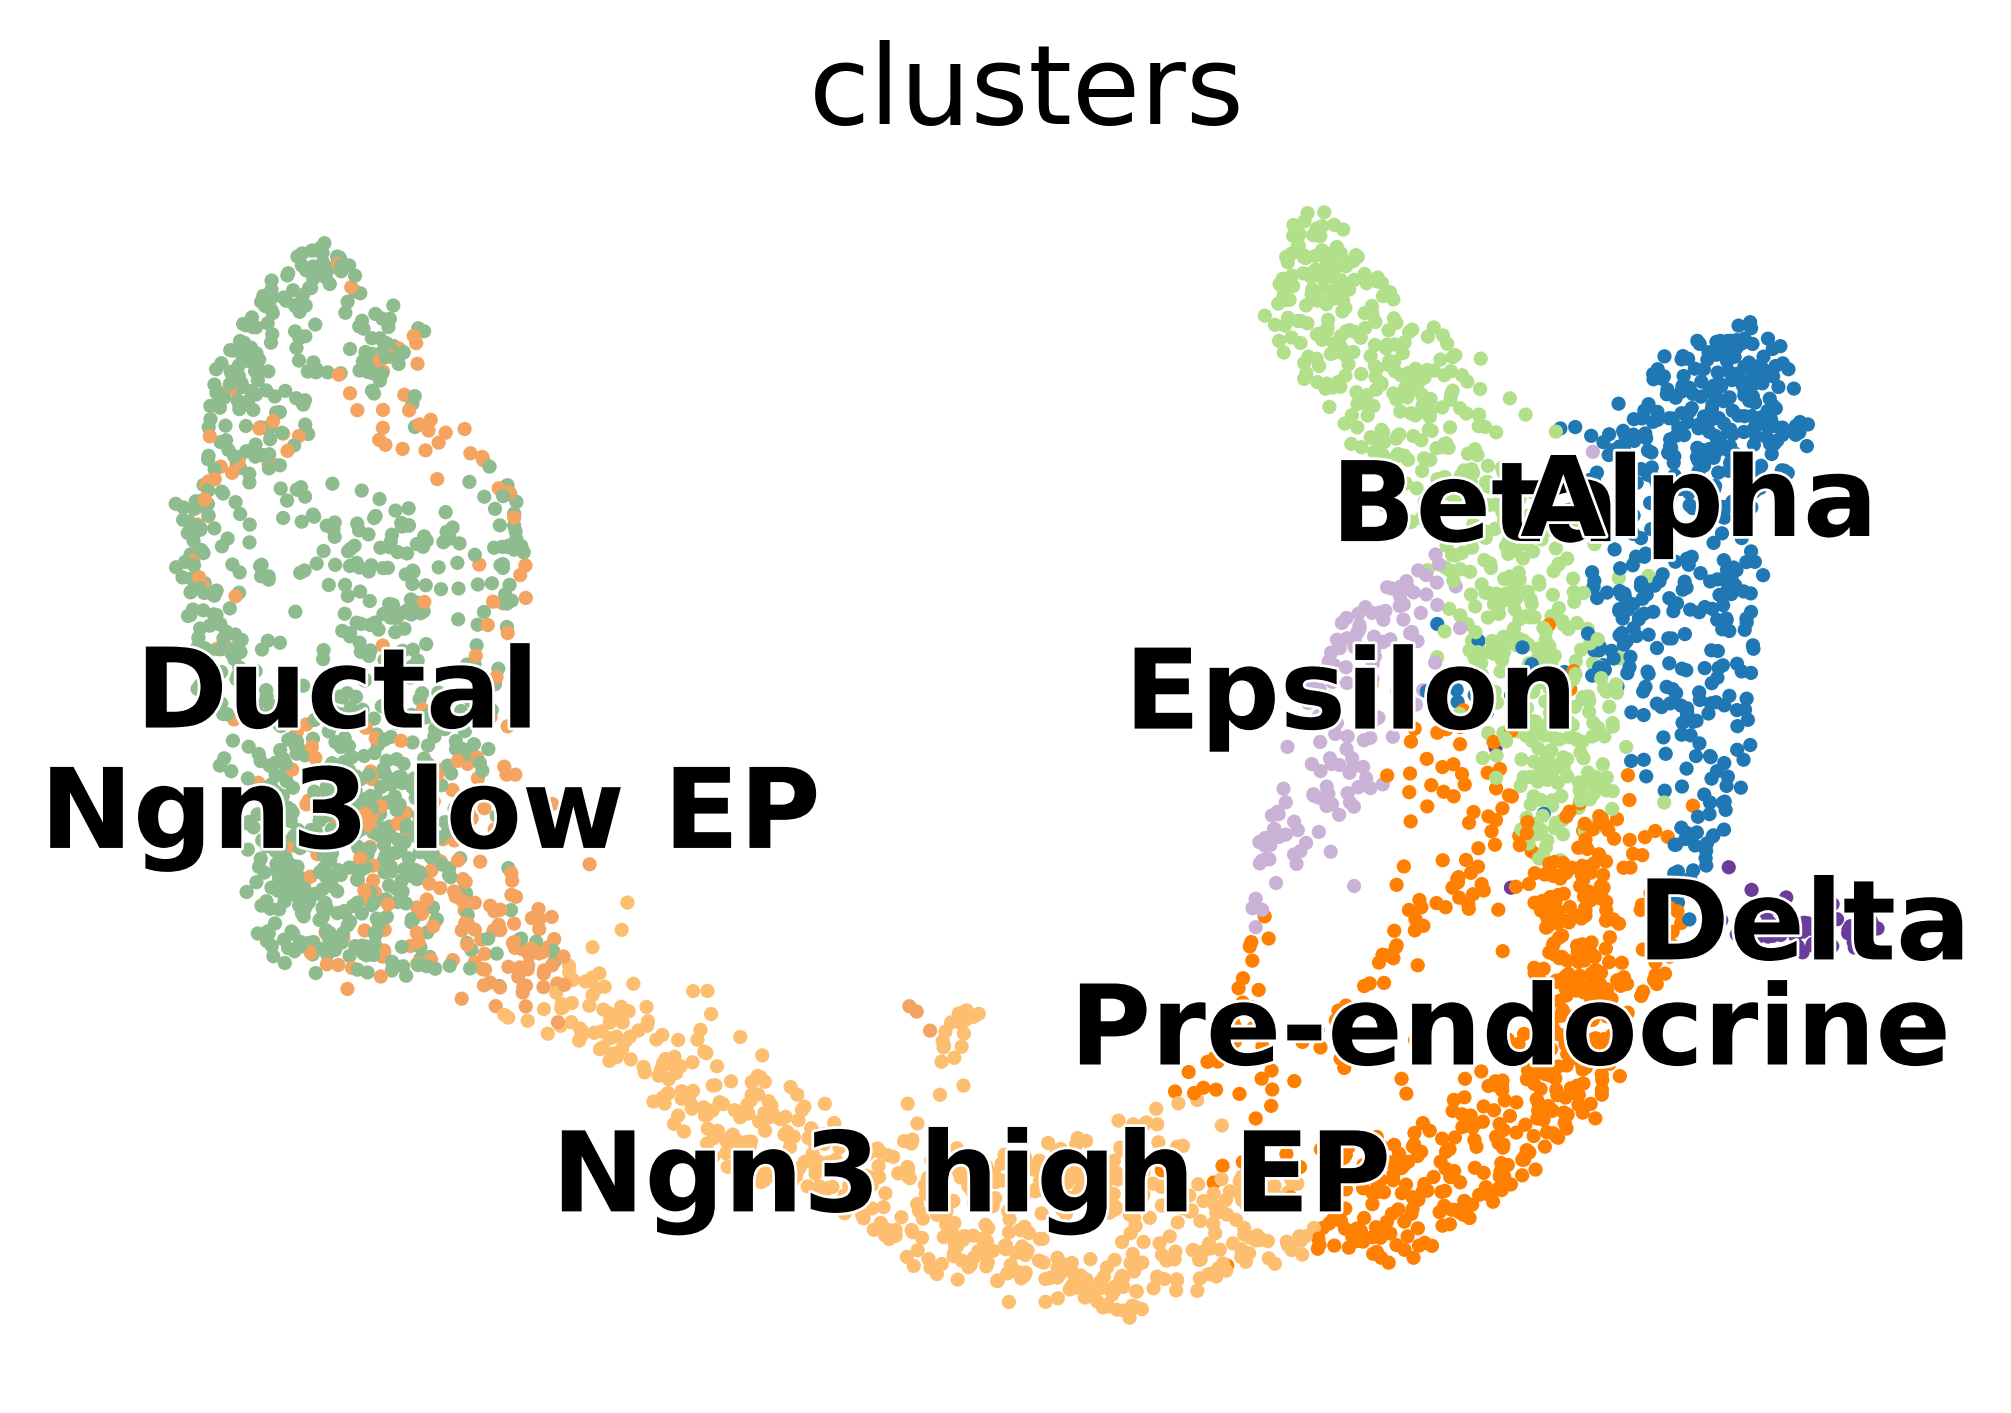

In [9]:
scv.pl.scatter(adata, basis='umap', c='clusters', dpi=200)

## Data preprocessing

In [10]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scaler = MinMaxScaler()
adata.layers["Mu"] = scaler.fit_transform(adata.layers["Mu"])

scaler = MinMaxScaler()
adata.layers["Ms"] = scaler.fit_transform(adata.layers["Ms"])

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Model fitting

/home/icb/philipp.weiler/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 465/500:  93%|█████████▎| 465/500 [02:08<00:09,  3.62it/s, loss=-3.89e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3726.740. Signaling Trainer to stop.


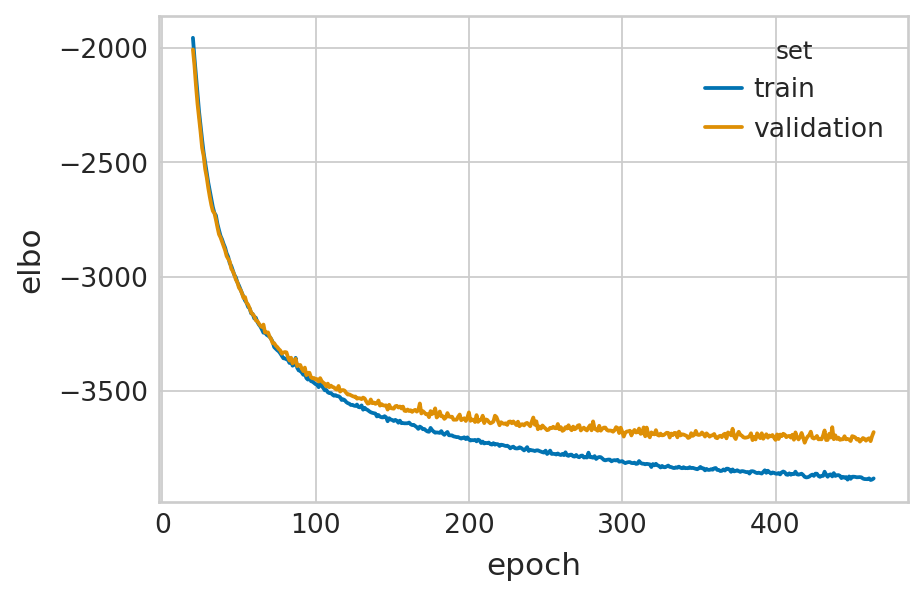

In [11]:
velovi_vae = fit_velovi(adata)

## Permutation score evaluation

In [12]:
perm_scores, permuted_adata = velovi_vae.get_permutation_scores(labels_key='clusters')

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [13]:
full_perm_df = pd.DataFrame(columns=["Score", "Dataset"])

max_ratio = np.nanmax(perm_scores.values, axis=1)
scores = max_ratio.tolist()
dataset = ['Pancreas'] * len(max_ratio)

full_perm_df["Score"] = scores
full_perm_df["Dataset"] = dataset

In [14]:
color = adata.obs['clusters'].astype(str).replace(
    dict(zip(adata.obs['clusters'].cat.categories, adata.uns['clusters_colors']))
).tolist()

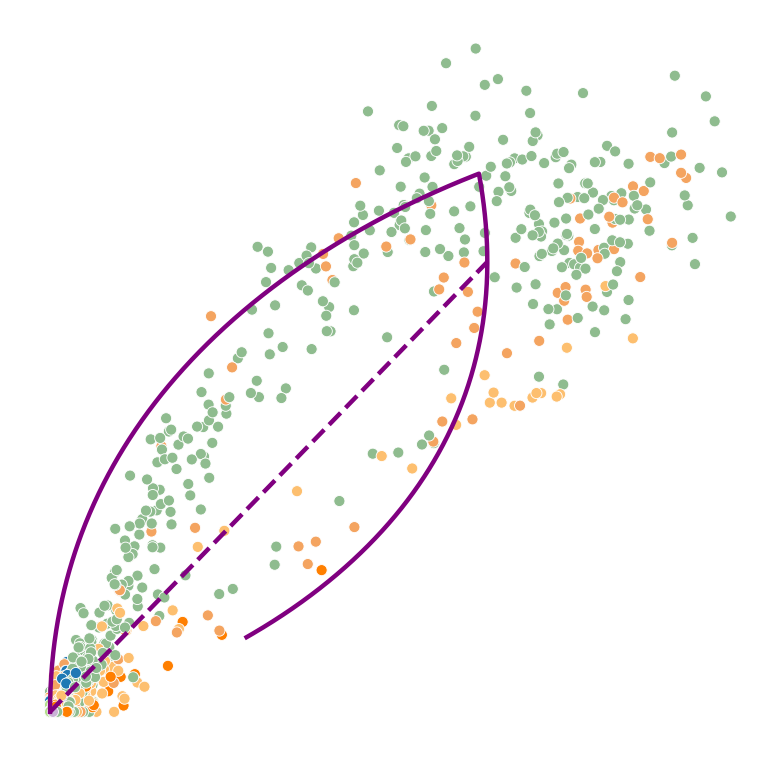

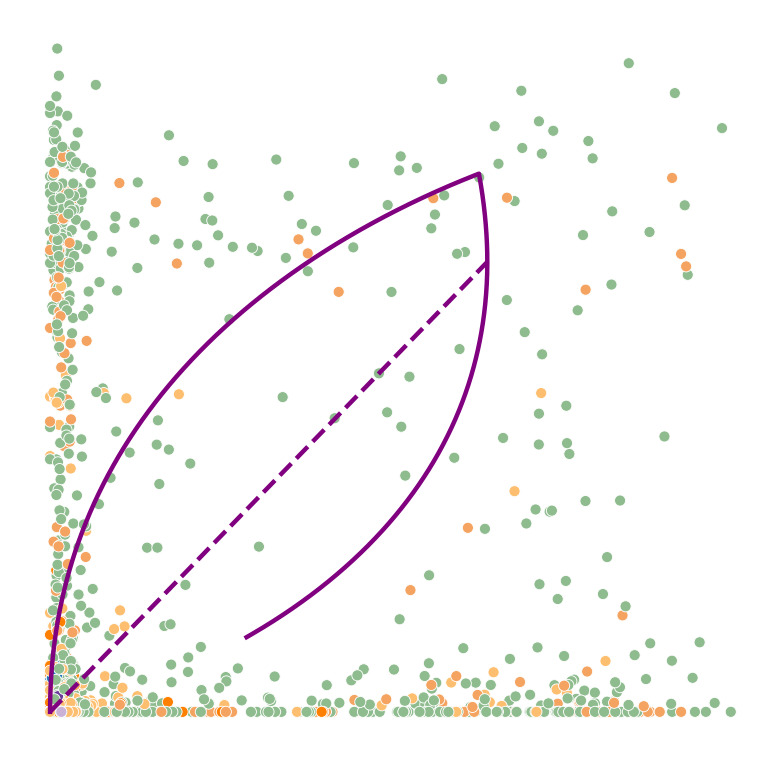

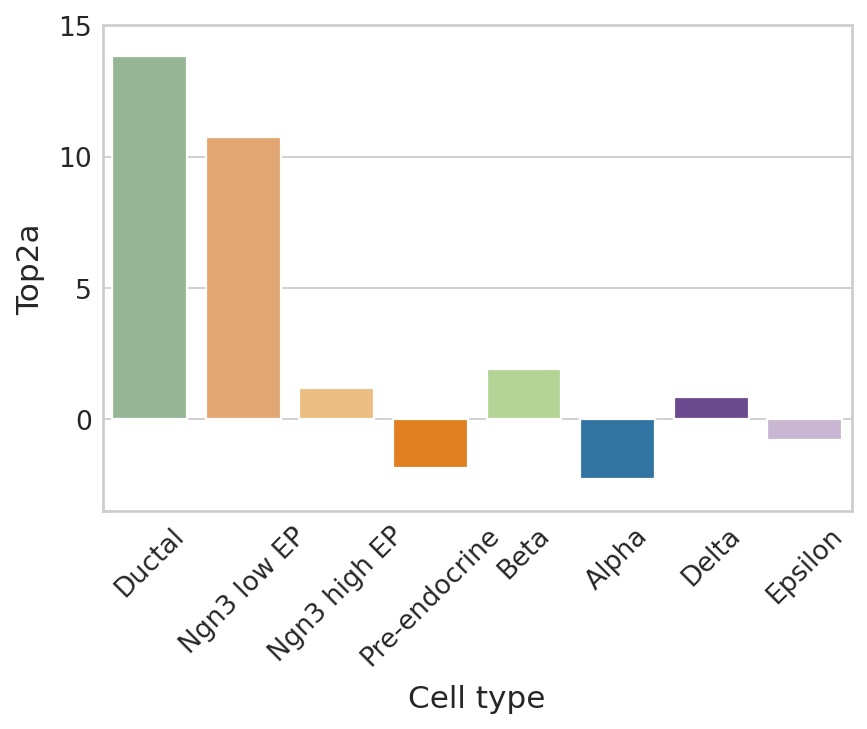

In [15]:
plot_phase_portrait(adata, 'Top2a', color)
plot_phase_portrait(permuted_adata, 'Top2a', color, permuted=True)
plot_perm_scores(adata, perm_scores, 'Top2a', 'clusters')

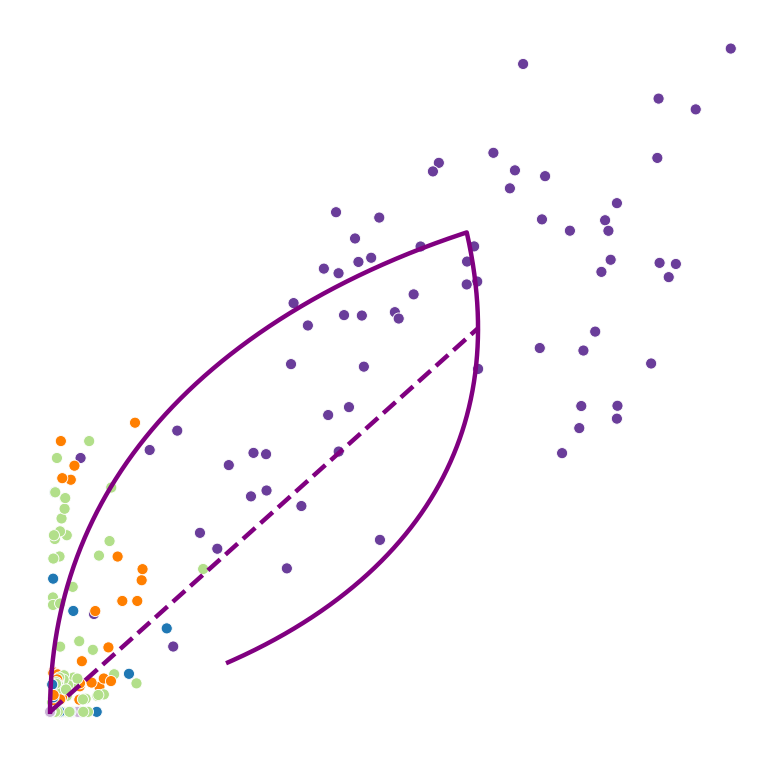

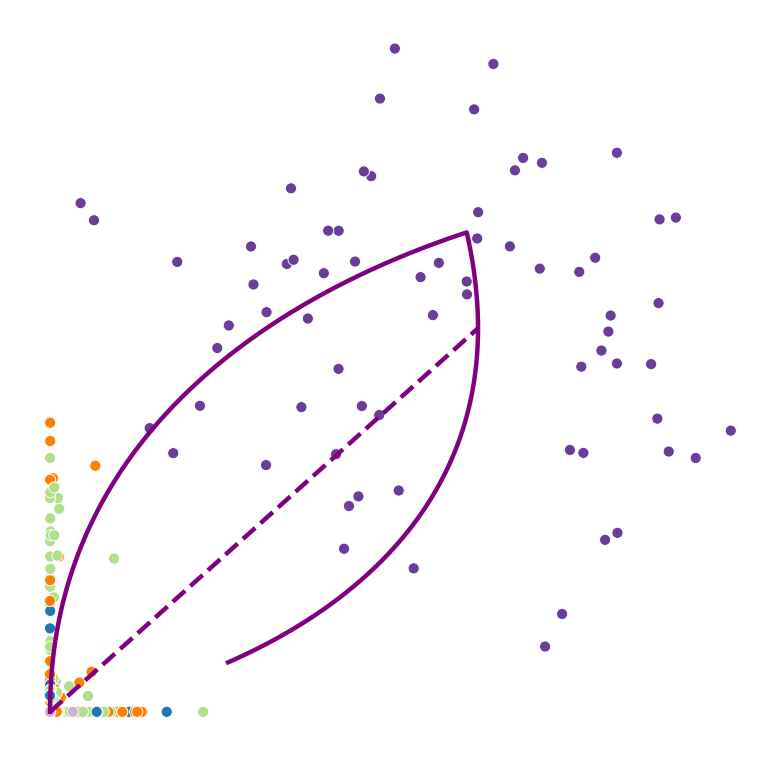

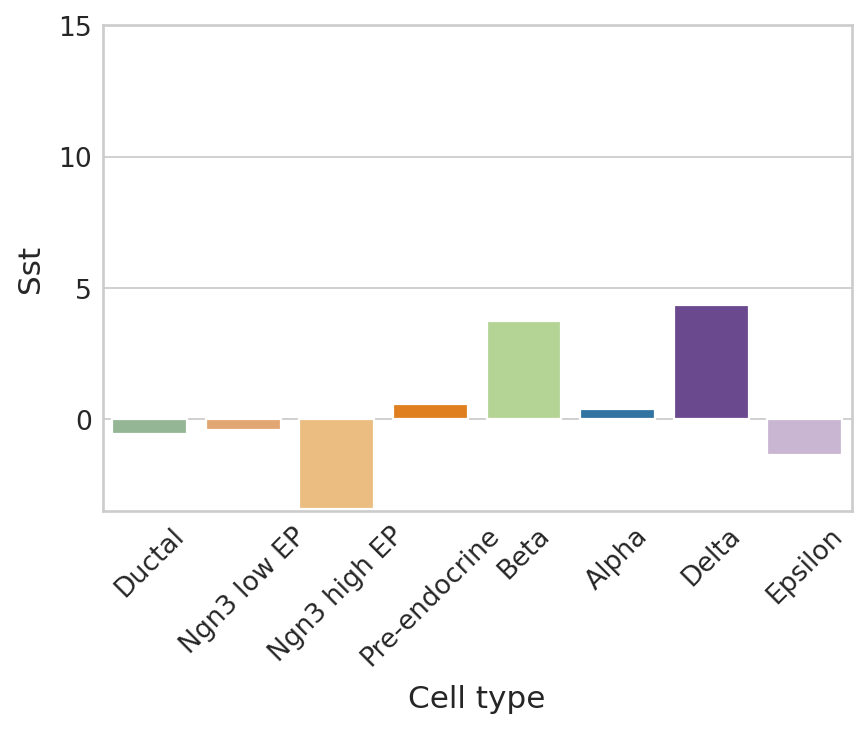

In [16]:
plot_phase_portrait(adata, 'Sst', color)
plot_phase_portrait(permuted_adata, 'Sst', color, permuted=True)
plot_perm_scores(adata, perm_scores, 'Sst', 'clusters')